# LED Analysis

This tutorial demonstrates how to use ORCA together with the ORCA python interface (OPI) to perform a **[Local Energy Decomposition (LED)](https://doi.org/10.1021/acs.jctc.6b00523)** analysis to decompose the interaction energy of a non-covalent host-guest complex. Additionally, post-processing for the **[fragment-pairwise LED (fp-LED)](https://doi.org/10.1002/anie.202421922)** is performed, which allows the decomposition of interaction energies in exclusively pair-wise contributions.

In this notebook we will:
1.  Import the required python dependencies.
2.  Define a working directory.
3.  Set up a host&ndash;guest input structure for our calculation.
4.  Run an LED calculation for the complete system.
5.  Assign a host and a guest automatically.
6.  Run calculations for host and guest.
7.  Perform post-processing for the standard LED.
8.  Perform post-processing for the fp-LED.
9.  Gather the results in pandas dataframes.
10. Visualize the LED interactions with heatmaps.
11. Interpretation of the results.

## Step 1: Import Dependencies

We start by importing the modules needed for:
- Interfacing with ORCA input/output
- Numerical calculations and data handling
- Plotting results

> **Note:** We additionally import modules for visualization/plotting like `py3Dmol`. For this, it might be necessary to install `py3Dmol` into your OPI `venv` (e.g., by activating the `.venv` and using `uv pip install py3Dmol`).

In [1]:
from pathlib import Path
import shutil

# > pandas and numpy for data handling
import pandas as pd
import numpy as np

# > OPI imports for performing ORCA calculations and reading the output
from opi.core import Calculator
from opi.output.core import Output
from opi.input.simple_keywords import BasisSet, Dlpno, \
    Scf, AuxBasisSet, Approximation, Wft
from opi.input.structures.structure import Structure

# > For plotting results visualization of molecules
import matplotlib.pyplot as plt
import seaborn as sns
import py3Dmol

## Step 2: Working Directory and Conversion Factor

We define a subfolder `RUN` in which the actual ORCA calculations will take place. Also, we define a conversion factor, since we want the resulting interaction energies in kcal/mol for better interpretability.

In [ ]:
# > Calculation is performed in `RUN`
working_dir = Path("RUN")
# > The `working_dir`is automatically (re-)created
shutil.rmtree(working_dir, ignore_errors=True)
working_dir.mkdir()
# > Conversion factor for atomic units to kcal/mol
unit_conversion = 627.509 

## Step 3: Setup the Input Structure

As an example we will look at the interaction of methanol with three water molecules. The 3D structure in Cartesian coordinates is defined and visualized:


In [3]:
# > Define cartesian coordinates in Angstroem as python string 
# > In principle, this can be replaced with other small neutral nci complexes
xyz_data = """\
15

O      1.88878   -1.95233   -0.28948
H      2.92501   -3.28661    0.90657
H      2.93956   -3.64997   -0.83856
H      1.44798   -3.87401    0.10426
C      2.33580   -3.25294   -0.01484
H      2.64332   -1.32264   -0.27726
O      0.00000    0.00000    0.00000
H     -0.61425   -0.07593   -0.73002
H      0.54322   -0.80712   -0.00284
O      1.86706    1.85104    0.75482
H      1.22835    1.18615    0.44091
H      1.34844    2.58596    1.08333
O      3.79229   -0.00000   -0.00000
H      3.21057    0.64166    0.42375
H      4.29234    0.44984   -0.68198\n
"""
# > Visualize the input structure
view = py3Dmol.view(width=400, height=400)
view.addModel(xyz_data, 'xyz')
view.setStyle({}, {'stick': {}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

# > Write the input structure to a file
with open(working_dir / "struc.xyz","w") as f:
    f.write(xyz_data)
# > Read structure into object
structure = Structure.from_xyz(working_dir / "struc.xyz")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 4: Run LED for the Supramolecular System

First, we run an LED calculation with DLPNO-CCSD(T)/def2-SVP for the complete system using `NORMALPNO` and `NORMALSCF` settings. We choose the small basis set and only moderate PNO and SCF settings to keep the computational costs for this notebook small. Note that these settings are usually not sufficient for production runs. The Fragments in the LED calculation will automatically be detected by ORCA (four fragments in this example, one for each molecule), but can also manually be assigned. We define and run three helper functions: `setup_calc`, `run_calc`, and `check_and_parse_output`. 

First, we set up the calculation with `setup_calc`:

In [4]:
def setup_calc(basename : str, working_dir: Path, structure: Structure, ncores: int = 4) -> Calculator:
    # > Set up a Calculator object
    calc = Calculator(basename=basename, working_dir=working_dir)
    # > Assign structure to calculator
    calc.structure = structure

    # > Define a simple keyword list for the ORCA calculation
    sk_list = [
    Wft.DLPNO_CCSD_T, # > Use DLPNO-CCSD(T)
    BasisSet.DEF2_SVP, # > Use the def2-SVP basis set
    AuxBasisSet.DEF2_SVP_C, # > Use the def2-svp/c auxiliary basis set
    AuxBasisSet.DEF2_J, # > Use the def2-svp/j auxiliary basis set
    Dlpno.NORMALPNO, # > normal PNO settings
    Scf.NORMALSCF, # > normal SCF settings
    Approximation.RIJCOSX, # > Use RIJCOSX
    Dlpno.LED, # > Make energy decomposition
    ]

    # use simple keywords in calculator
    calc.input.add_simple_keywords(*sk_list)

    # Define number of CPUs for the calcualtion
    calc.input.ncores = ncores # > 4 CPUs for this ORCA run

    return calc

calc_supersystem = setup_calc("supersystem", working_dir=working_dir, structure=structure)

Then we run the calculation with `run_calc` and obtain the output:

In [5]:
def run_calc(calc: Calculator) -> Output:
    # > Write the ORCA input file
    calc.write_input()
    # > Run the ORCA calculation
    print("Running ORCA calculation ...", end="")
    calc.run()
    print("   Done")

    # > Get the output object
    output = calc.get_output()
    
    return output

output_supersystem = run_calc(calc_supersystem)

Running ORCA calculation ...   Done


The successful calculation has to be checked and parsed, which is done in `check_and_parse_output`:

In [6]:
def check_and_parse_output(output: Output):
    # > Check for proper termination of ORCA
    status = output.terminated_normally()
    if not status:
        # > ORCA did not terminate normally
        raise RuntimeError(f"ORCA did not terminate normally, see output file: {output.get_outfile()}")
    else:
        # > ORCA did terminate normally so we can parse the output
        output.parse()

    # Now check for convergence of the SCF
    if output.results_properties.geometries[0].single_point_data.converged:
        print("ORCA terminated normally and the SCF converged")
    else:
        raise RuntimeError("SCF DID NOT CONVERGE")
    
check_and_parse_output(output_supersystem)

ORCA terminated normally and the SCF converged


## Step 5: Definition of Subsystems
Next, we extract the automatically generated fragments, save them to a dictionary, and define a host and a guest subsystem. In our example, methanol is the guest and the water cluster is the host.

In [7]:
# > Shortcut to the fragments data
frags = output_supersystem.results_properties.geometries[0].geometry.fragments
# > Obtain the number of fragments in the led (fragment numbering continuous)
nfrags = int(output_supersystem.results_properties.geometries[0].mdci_led.numoffragments)

# > Generate a list of atoms in the fragments
atoms_in_frag = [[] for _ in range(nfrags)]
for index, value in enumerate(frags):
    frag_id = int(value[0])
    atoms_in_frag[frag_id-1].append(index)
    structure.atoms[index].fragment_id = frag_id

# > Define a list of atoms in the subsystems
atoms_in_sub = [] 
atoms_in_sub.append(atoms_in_frag[0])   #> First subsystem (guest) contains the first fragment which is methanol
atoms_in_sub.append([atom for frag in atoms_in_frag[1:] for atom in frag])  #> Second subsystem (host) contains all the other fragments which are the water molecules
nsub = len(atoms_in_sub)

# > Define a list of fragments in the subsystems
frag_in_sub = [[] for _ in range(nsub)]
for ifrag in range(nfrags):
    if ifrag == 0: frag_in_sub[0].append(ifrag) # > First fragment is the guest (first subsystem)
    if ifrag > 0: frag_in_sub[1].append(ifrag)  # > All other fragments are the host (second subsystem)

# > Visualize the fragments 
print("Here, the fragment IDs are depicted:")
for atom in structure.atoms:
    x, y, z = atom.coordinates.coordinates
    view.addLabel(f"{atom.fragment_id}", {
        'position': {'x': x, 'y': y, 'z': z},
        'backgroundColor': 'black',
        'fontColor': 'white',
        'showBackground': True,
        'fontSize': 12
    })
view.show()

# Set the fragment IDs to None, so that the autofragmentator can assign them
for index, value in enumerate(frags):
    structure.atoms[index].fragment_id = None

Here, the fragment IDs are depicted:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 6: Run the Host and Guest Calculations

After defining the host&ndash;guest system, we run the LED calculations for the subsystems. Here we can utilize the helper functions defined above:

In [8]:
sub_outputs: list[Output] = []
# > Loop over subsystems (host and guest), obtain substructures, and perform calculations
for i in range(len(atoms_in_sub)):
    
    # > Prepare calculation for the subsystem 
    subsystem = i + 1
    sub_structure = calc_supersystem.structure.extract_substructure(atoms_in_sub[i])
    calc_subsystem = setup_calc(f"subsystem_{subsystem}", working_dir, sub_structure)

    
    # > Visualize the subsystem for which the calculation will run
    # > First remove fragment data for visualization
    for atom in calc_subsystem.structure.atoms: atom.fragment_id = None
    xyz_data = calc_subsystem.structure.to_xyz_block()
    # > Visualize the subsystem with py3Dmol
    view_sub = py3Dmol.view(width=400, height=400)
    view_sub.addModel(xyz_data, 'xyz')
    view_sub.setStyle({}, {'stick': {}, 'sphere': {'scale': 0.3}})
    view_sub.zoomTo()
    print("Visualizing the guest:" if subsystem == 1 else "Visualizing the host:")
    view_sub.show()

    # > Run the calculation
    output_sub = run_calc(calc_subsystem)

    # > Check and parse the output
    check_and_parse_output(output_sub)

    sub_outputs.append(output_sub)

Visualizing the guest:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Running ORCA calculation ...   Done
ORCA terminated normally and the SCF converged
Visualizing the host:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Running ORCA calculation ...   Done
ORCA terminated normally and the SCF converged


## Step 7: Processing for Standard LED

Now, we can extract the energies for a standard LED.

In [9]:
# > Shortcut to the LED data for the supersystem
led_data = output_supersystem.results_properties.geometries[0].mdci_led
# > Number of subsystems is two
nsub = 2
# > Number of fragments
nfrags = int(output_supersystem.results_properties.geometries[0].mdci_led.numoffragments)

# > Define shortcuts to the CCSD(T) energies for the subsystems (host and guest)
sub_outputs_energy = []
sub_outputs_led = []
for output in sub_outputs:
    # > energy[0] will be the SCF energy and energy[1] the CCSD(T) energy
    sub_outputs_energy.append(output.results_properties.geometries[0].energy[1])
    sub_outputs_led.append(output.results_properties.geometries[0].mdci_led)

# > Define variables to store the LED data
LED_pairwise_Total = {}
LED_pairwise_Ref = {}
LED_pairwise_Corr = {}
LED_pairwise_Ref_Coulomb = {}
LED_pairwise_Ref_Exch = {}
LED_pairwise_Corr_Disp = {}

# > First, we collect the results from the suprasystem LED calculation
for x in range(nfrags):
    for y in range(x + 1):
        pair = (x, y)
        E_tot = led_data.totint[x][y]
        E_ref = led_data.refint[x][y]
        E_corr = led_data.corrint[x][y]
        LED_pairwise_Ref[pair] = E_ref
        LED_pairwise_Corr[pair] = E_corr
        LED_pairwise_Total[pair] = E_tot
        if x != y:
            E_ref_elstat = led_data.electrostref[x][y]
            E_ref_exch = led_data.exchangeref[x][y]
            E_corr_disp = led_data.dispcontr[x][y] + led_data.dispweak[x][y]
            LED_pairwise_Ref_Coulomb[pair] = E_ref_elstat
            LED_pairwise_Ref_Exch[pair] = E_ref_exch
            LED_pairwise_Corr_Disp[pair] = E_corr_disp

# > Now, we substract the results from the subsystem LED calculations
for x in range(nfrags):
    for y in range(x + 1):
        pair = (x, y)
        E_ref = 0.
        E_corr = 0.
        foundPair = False
        # > Check if both fragments are the guest
        if x in frag_in_sub[0] and y in frag_in_sub[0]:
            foundPair = True
            # > Since the guest subsystem is only one fragment, no led data will be present
            # > and this will always be false
            if sub_outputs_led[0]: 
                E_ref = sub_outputs_led[0].refint[x][y]
                E_corr = sub_outputs_led[0].corrint[x][y]
                if x != y: 
                    E_ref_elstat = sub_outputs_led[0].electrostref[x][y]
                    E_ref_exch = sub_outputs_led[0].exchangeref[x][y]
                    E_corr_disp = sub_outputs_led[0].dispcontr[x][y] + sub_outputs_led[0].dispweak[x][y]
            else:
                E_ref = sub_outputs_energy[0].refenergy[0][0]
                E_corr = sub_outputs_energy[0].correnergy[0][0]
        # > Check if both fragments are on the host
        elif x in frag_in_sub[1] and y in frag_in_sub[1]:
            foundPair = True
            # > The host subsystem does not include the first (guest) fragment
            # > Therefore, x and y have to be shifted if multiple fragments are present
            if sub_outputs_led[1]:
                E_ref = sub_outputs_led[1].refint[x-1][y-1]
                E_corr = sub_outputs_led[1].corrint[x-1][y-1]
                if x != y and sub_outputs_led[1]:
                    E_ref_elstat = sub_outputs_led[1].electrostref[x-1][y-1]
                    E_ref_exch = sub_outputs_led[1].exchangeref[x-1][y-1]
                    E_corr_disp = sub_outputs_led[1].dispcontr[x-1][y-1] + sub_outputs_led[1].dispweak[x-1][y-1]
            else:
                E_ref = sub_outputs_energy[1].refenergy[0][0]
                E_corr = sub_outputs_energy[1].correnergy[0][0]

        # > Subtract the calculated data from the subsystems
        if foundPair:
            LED_pairwise_Ref[pair] -= E_ref
            LED_pairwise_Corr[pair] -= E_corr
            LED_pairwise_Total[pair] -= (E_ref + E_corr)
            if x != y:
                LED_pairwise_Ref_Coulomb[pair] -= E_ref_elstat
                LED_pairwise_Ref_Exch[pair] -= E_ref_exch
                LED_pairwise_Corr_Disp[pair] -= E_corr_disp

## Step 8: Processing for fp-LED

Next, we use the LED results and post-process them to fp-LED results, where the interaction energy is decomposed into only pair-wise terms. We calculate the scaling factors from absolute values for better numerical stability. The scaling is done for the total energies and for the reference energies, while the correlations contributions are obtained from subtracting the reference energies from the total energies.

In [10]:
def fp_analysis_abs():
    for x in range(nfrags):
        for y in range(x):
            pairXY = (x,y)
            pairXX = (x,x)
            pairYY = (y,y)
            E_Total_XY_unscaled = LED_pairwise_Total[pairXY]
            dE_Total_X_unscaled = LED_pairwise_Total[pairXX]
            dE_Total_Y_unscaled = LED_pairwise_Total[pairYY]
            E_Ref_XY_unscaled = LED_pairwise_Ref[pairXY]
            dE_Ref_X_unscaled = LED_pairwise_Ref[pairXX]
            dE_Ref_Y_unscaled = LED_pairwise_Ref[pairYY]
            denom_X_Total = 0
            denom_Y_Total = 0
            denom_X_Ref = 0
            denom_Y_Ref = 0
            # > Calculate the denominator of the weights with absolute values
            for k in range(nfrags):
                minXK = min(x, k)
                maxXK = max(x, k)
                pairXK = (maxXK, minXK)
                E_Total_XK_unscaled = LED_pairwise_Total[pairXK]
                E_Ref_XK_unscaled = LED_pairwise_Ref[pairXK]
                if k != x:
                    denom_X_Total += abs(E_Total_XK_unscaled)
                    denom_X_Ref += abs(E_Ref_XK_unscaled)
                minYK = min(y, k)
                maxYK = max(y, k)
                pairYK = (maxYK, minYK)
                E_Total_YK_unscaled = LED_pairwise_Total[pairYK]
                E_Ref_YK_unscaled = LED_pairwise_Ref[pairYK]
                if k != y:
                    denom_Y_Total += abs(E_Total_YK_unscaled)
                    denom_Y_Ref += abs(E_Ref_YK_unscaled)
            scalingX_Total = dE_Total_X_unscaled / denom_X_Total
            scalingY_Total = dE_Total_Y_unscaled / denom_Y_Total
            scaling_Total = scalingX_Total + scalingY_Total
            scalingX_Ref = dE_Ref_X_unscaled / denom_X_Ref
            scalingY_Ref = dE_Ref_Y_unscaled / denom_Y_Ref
            scaling_Ref = scalingX_Ref + scalingY_Ref
            # > Take the absolute values of the interfragment contributions
            E_Total_XY_scaled = scaling_Total * abs(E_Total_XY_unscaled)
            E_Ref_XY_scaled = scaling_Ref * abs(E_Ref_XY_unscaled)
            E_Corr_XY_scaled = E_Total_XY_scaled - E_Ref_XY_scaled
            # > Calculate Elprep contributions
            LED_pairwise_Ref_Elprep[pairXY] = E_Ref_XY_scaled
            LED_pairwise_Corr_Elprep[pairXY] = E_Corr_XY_scaled
            LED_pairwise_Total_Elprep[pairXY] = E_Total_XY_scaled
    
    # > Add the Elprep contributions
    for x in range(nfrags):
        for y in range(x):
            pairXY = (x, y)
            LED_pairwise_Ref[pairXY] += LED_pairwise_Ref_Elprep[pairXY]
            LED_pairwise_Corr[pairXY] += LED_pairwise_Corr_Elprep[pairXY]
            LED_pairwise_Total[pairXY] += LED_pairwise_Total_Elprep[pairXY]
    
    # > Set the intra-fragment contributions that were distributed to zero
    for x in range(nfrags):
        pair = (x,x)
        LED_pairwise_Total[pair] = 0.
        LED_pairwise_Ref[pair] = 0.
        LED_pairwise_Corr[pair] = 0.
        LED_pairwise_Ref_Coulomb[pair] = 0.
        LED_pairwise_Ref_Exch[pair] = 0.
        LED_pairwise_Corr_Disp[pair] = 0.

LED_pairwise_Total_Elprep = {}
LED_pairwise_Ref_Elprep = {}
LED_pairwise_Corr_Elprep = {}
# > Run the actual analysis
fp_analysis_abs()

## Step 9: Gather the Results in pandas Dataframes

For easier access, we store the results in a dictonary of pandas dataframes.

In [11]:
# > Function for generating pandas dataframes
def gen_led_frame(led_dict: dict[tuple[int,int], float]) -> pd.DataFrame:
    # Create a full 2D array filled with NaNs
    grid = np.full((nfrags, nfrags), np.nan)

    # > Fill the grid with LED results
    for (x, y), value in led_dict.items():
        grid[y, x] = value * unit_conversion

    # > Convert to DataFrame
    df = pd.DataFrame(grid)
    # > offset indices by 1 to start counting with 1
    df.index += 1
    df.columns += 1

    return df

# > Generation of data frames
data_frames = {}
data_frames["LED_Total"] = gen_led_frame(LED_pairwise_Total)
data_frames["LED_Corr"] = gen_led_frame(LED_pairwise_Corr)
data_frames["LED_Ref"] = gen_led_frame(LED_pairwise_Ref)
data_frames["LED_Ref_Coulomb"] = gen_led_frame(LED_pairwise_Ref_Coulomb)
data_frames["LED_Ref_Exch"] = gen_led_frame(LED_pairwise_Ref_Exch)
data_frames["LED_Corr_Disp"] = gen_led_frame(LED_pairwise_Corr_Disp)
data_frames["LED_Total_Elprep"] = gen_led_frame(LED_pairwise_Total_Elprep)
data_frames["LED_Ref_Elprep"] = gen_led_frame(LED_pairwise_Ref_Elprep)
data_frames["LED_Corr_Elprep"] = gen_led_frame(LED_pairwise_Corr_Elprep)

## Step 10: Visualization of the Results in Heatmaps

For visualizing the fp-LED total interaction energy, we can use a heatmap:

Visualization of fragments:


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Total interaction energy is -20.3 kcal/mol


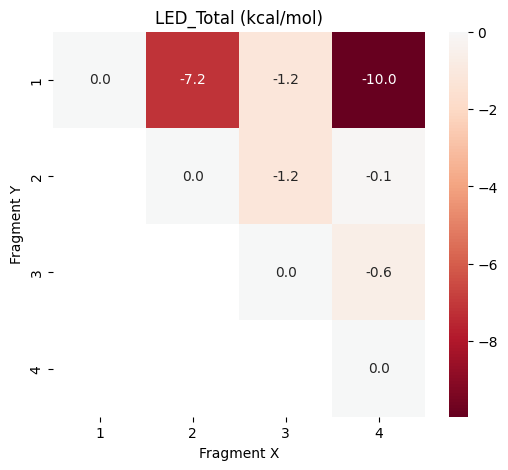

In [12]:
# Function to plot the results in a heatmap
def plot_led(name: str, df: pd.DataFrame):
    plt.figure(figsize=(6, 5))
    sns.heatmap(df, annot=True, fmt=".1f", cmap="RdBu", center=0)
    plt.title(f"{name} (kcal/mol)")
    plt.xlabel("Fragment X")
    plt.ylabel("Fragment Y")
    plt.show()

# > Show the structure with fragment IDs once more
print("Visualization of fragments:")
view.show()

# > Calculate the total interaction energy between fragment 1 and everything else
etot = np.nansum(data_frames["LED_Total"].to_numpy())
print(f"Total interaction energy is {etot:.1f} kcal/mol")

# > Actually plot the heatmap
plot_led("LED_Total",data_frames["LED_Total"])

## Step 11: Interpretation of the Results
The heatmap shown above visualizes the pair-wise contributions to the host-guest interaction energy. The overall interaction energy is negative and as expected the contributions between methanol (fragment 1) and the water molecules with direct hydrogen bonds to it (fragment 2 and 4) have the largest contributions to the overall interaction energy. We take a closer look at the contributions from the Hartee-Fock (HF) reference function `LED_Ref` and the correlation contribution `LED_Corr`:  

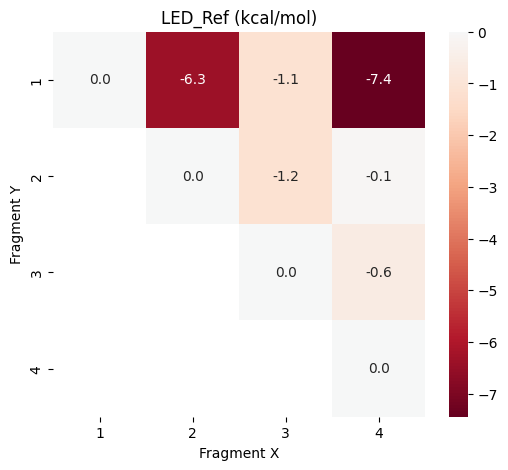

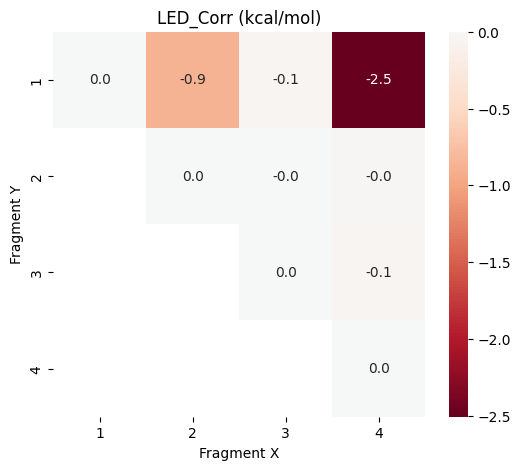

In [13]:
plot_led("LED_Ref",data_frames["LED_Ref"])
plot_led("LED_Corr",data_frames["LED_Corr"])

It can be seen that the largest part of the hydrogen bond interactions is already described at the HF reference level, while the correlation contributions are smaller but critical for accuracy. 
> **Note:** If you are interested in the other contributions you can download this notebook, run it on your computer, and plot the other heatmaps with the functionality provided here.

## Notes on performing LED calculations
The shown LED analysis can be applied to all host-guest complexes with neutral charge and no covalent bonds between them. The first fragment automatically found by the ORCA fragmentator will always be the guest and all the other fragments the host.